In [15]:
# %matplotlib widget
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from qokit.parameter_utils import get_fixed_gamma_beta


method = "LN_COBYLA (NLopt)"
problem = "maxcut"
p = 5
n = 12
seed_pool = list(range(1000))

data = pickle.load(
    open(
        f"data/{problem}/configs/max_ar/LN_COBYLA (NLopt)-p{p}-q{n}-s0-999.pckl",
        "rb",
    ),
)
gamma, beta = get_fixed_gamma_beta(3, p)
optimal_params = data["optimal_params"] - np.concatenate([gamma, [b * 4 for b in beta]])
max_ar = data["result"][:len(seed_pool),np.newaxis,np.newaxis]

data = pickle.load(
    open(
        f"data/{problem}/configs/budget-fix-beta/{method}-p{p}-q{n}-s{seed_pool[0]}-{seed_pool[-1]}.pckl",
        "rb",
    ),
)
config = data["config"]
result = data["result"][:,:,:]
initial_ar = np.array(data["initial_ar"])[:,np.newaxis,np.newaxis]

print(config, result.shape)
shots_pool = [d["shots"] for d in config["executor_kwargs"]][:]
maxfev_pool = config["maxeval"][:]


{'initial_point': [[0.7191788139, 1.4131452052, 1.6451130953000002, 2.0095097897, 2.3085491637]], 'maxeval': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50], 'initial_step': [0.1], 'ftol_rel': [1e-13], 'executor_kwargs': [{'shots': 1428}, {'shots': 1250}, {'shots': 1111}, {'shots': 1000}, {'shots': 909}, {'shots': 833}, {'shots': 769}, {'shots': 714}, {'shots': 666}, {'shots': 625}, {'shots': 588}, {'shots': 555}, {'shots': 526}, {'shots': 500}, {'shots': 400}, {'shots': 333}, {'shots': 285}, {'shots': 250}, {'shots': 222}, {'shots': 200}]} (1000, 20, 20)


In [16]:
result = (result - initial_ar) / (max_ar - initial_ar)
# result = result[((max_ar - initial_ar) < 0.05).flat]
print(result.shape)

print((initial_ar.flatten() - max_ar.flatten())[:10])
print(np.sort((max_ar - initial_ar).flat)[-1:-6:-1])


(1000, 20, 20)
[-0.02968105 -0.00941204 -0.0146526  -0.02784286 -0.04915579 -0.05899806
 -0.01372665 -0.01061812 -0.02453645 -0.00832525]
[0.46455068 0.41733664 0.36973051 0.35124437 0.29166835]


Text(0.5, 1.0, 'maxcut p=5 n=12')

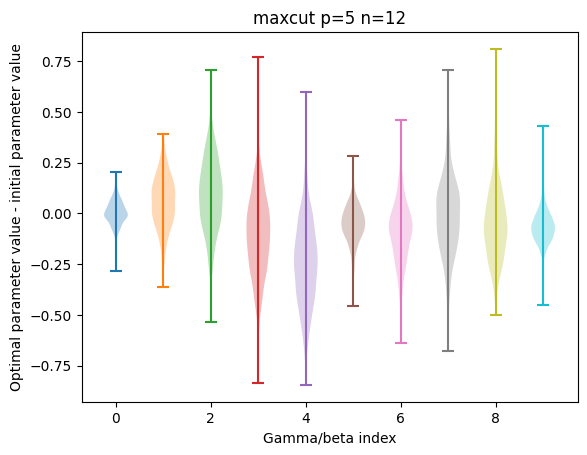

In [17]:
plt.figure()
for i in range(2 * p):
    plt.violinplot(optimal_params[:,i], [i])
# plt.ylim(0, np.pi)
plt.ylabel("Optimal parameter value - initial parameter value")
plt.xlabel("Gamma/beta index")
plt.title(f"{problem} {p=} {n=}")


In [11]:
# print("Initial AR:", np.mean(initial_ar))
mean_ar = np.mean(result, axis=0)
indices = np.argsort(mean_ar.flat)[-1:-100:-1]
for r, c in zip(mean_ar.flatten()[indices], config.interpret(indices)):
    print(r, c)


0.21649698737152467 ['maxeval=25', "executor_kwargs={'shots': 2000}"]
0.21341685647400122 ['maxeval=15', "executor_kwargs={'shots': 2000}"]
0.21009421204317463 ['maxeval=35', "executor_kwargs={'shots': 2000}"]
0.2060070125002573 ['maxeval=19', "executor_kwargs={'shots': 2000}"]
0.20396539563378407 ['maxeval=14', "executor_kwargs={'shots': 2000}"]
0.20253227946531527 ['maxeval=45', "executor_kwargs={'shots': 2000}"]
0.200004485699645 ['maxeval=40', "executor_kwargs={'shots': 2000}"]
0.19640541251415214 ['maxeval=10', "executor_kwargs={'shots': 2000}"]
0.1959990288905097 ['maxeval=20', "executor_kwargs={'shots': 2000}"]
0.1950723060473722 ['maxeval=17', "executor_kwargs={'shots': 2000}"]
0.19479418281724448 ['maxeval=8', "executor_kwargs={'shots': 2000}"]
0.19451940655557373 ['maxeval=16', "executor_kwargs={'shots': 2000}"]
0.19255214773695364 ['maxeval=30', "executor_kwargs={'shots': 2000}"]
0.1910282393442801 ['maxeval=40', "executor_kwargs={'shots': 1666}"]
0.19099847223974314 ['maxev

Text(0.5, 0, 'relative AR improvement')

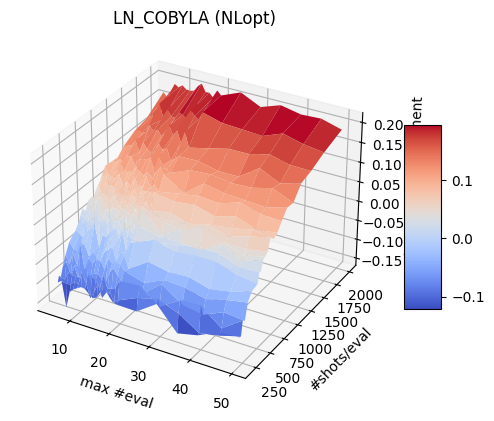

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(maxfev_pool, shots_pool, indexing='ij')
z = np.mean(result, axis=0)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
# ax.plot_surface(x, y, np.ones_like(z) * np.mean(initial_ar), cmap=cm.coolwarm, linewidth=0, antialiased=True, rstride=1, cstride=1, edgecolor='none')
ax.set_title(method)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_ylabel('#shots/eval')
ax.set_xlabel('max #eval')
ax.set_zlabel('relative AR improvement')
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}-3d.png")


Text(0.5, 1.0, 'maxcut p=3 n=12')

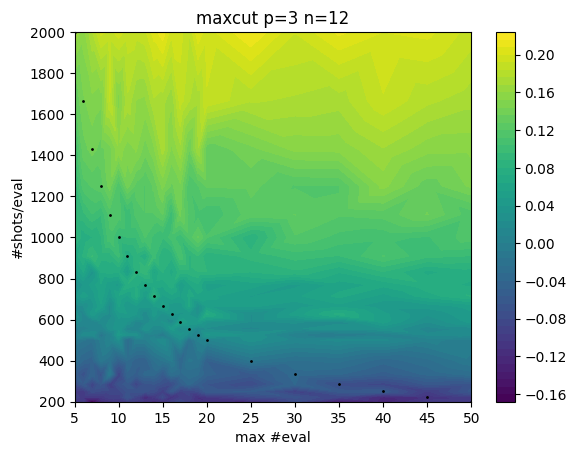

In [13]:
budget = 10000

plt.figure()
x, y = np.meshgrid(maxfev_pool, shots_pool, indexing='ij')
z = np.mean(result, axis=0)
fig = plt.tricontourf(x.flat, y.flat, z.flat, levels=50)
plt.plot(maxfev_pool, budget / np.array(maxfev_pool), "ko", ms=1)
plt.colorbar(fig)
plt.xlabel('max #eval')
plt.ylabel('#shots/eval')
plt.title(f"{problem} {p=} {n=}")
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}.png")


Text(0.5, 1.0, 'maxcut p=3 n=12')

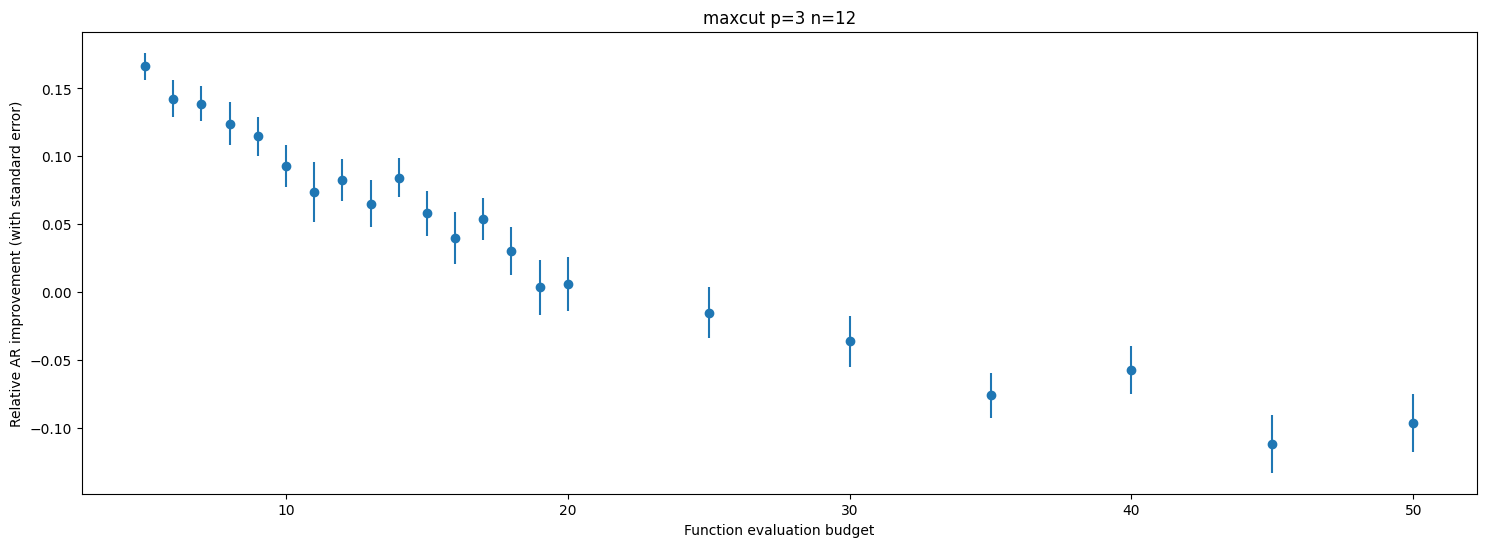

In [14]:
plt.figure(figsize=(18, 6))
# plt.violinplot(
#     [result[:, j, j] for j in range(len(shots_pool))],
#     maxfev_pool,
#     widths=1,
#     showmeans=True,
#     quantiles=[[0.25, 0.75]] * len(shots_pool),
# )
# plt.ylim([0, 1])
plt.errorbar(
    maxfev_pool,
    [np.mean(result, axis=0)[i, i] for i in range(len(shots_pool))],
    yerr=[np.std(result[:, i, i]) / np.sqrt(result.shape[0]) for i in range(len(shots_pool))],
    fmt="o",
)
plt.ylabel("Relative AR improvement (with standard error)")
plt.xlabel("Function evaluation budget")
plt.title(f"{problem} {p=} {n=}")
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}-slice.png")


238
165
112
80
51
46
35
33
22
26
20
19
23
19
18
8
16
12
12
9
9
12
8
7
[7.29213089e-05 1.34047688e-04 6.11324496e-04 7.26434646e-05
 1.97556029e-04 7.78034849e-07 5.76524120e-04]
[[ 9.84143957e-01  9.84143957e-01  8.04599659e-01  9.84143957e-01
   0.00000000e+00 -6.16775804e-01 -1.40377068e+00 -3.37746434e+00
   3.39904909e-02  9.84143957e-01 -7.04690858e-02 -3.37746434e+00
  -5.87799906e+00  8.04599659e-01 -1.35354875e-04  9.73981244e-01
   5.74721363e-01  9.18883479e-01 -5.88889507e+00  5.16054998e-02
  -3.37746432e+00 -3.36868668e+00 -9.98241539e-01  9.89314700e-01]
 [-3.65021771e+01 -1.17136984e+01 -4.20219469e+00 -1.66019073e+00
  -1.66019073e+00  2.90785139e-01 -1.66019073e+00 -3.65021771e+01
  -4.20219469e+00 -1.18224667e+01 -1.68512835e+00 -1.69233803e+01
   9.93987903e-02  7.75986006e-02 -4.62277338e+01 -3.85010079e+01
  -4.45665367e+01 -3.25848925e+01 -7.31721668e-01 -7.43407679e+01
  -1.55688755e+01 -1.72706919e+01 -1.85266208e+02  5.29241720e-01]
 [ 0.00000000e+00  1.1903667

Text(0.5, 1.0, 'maxcut p=1 n=12')

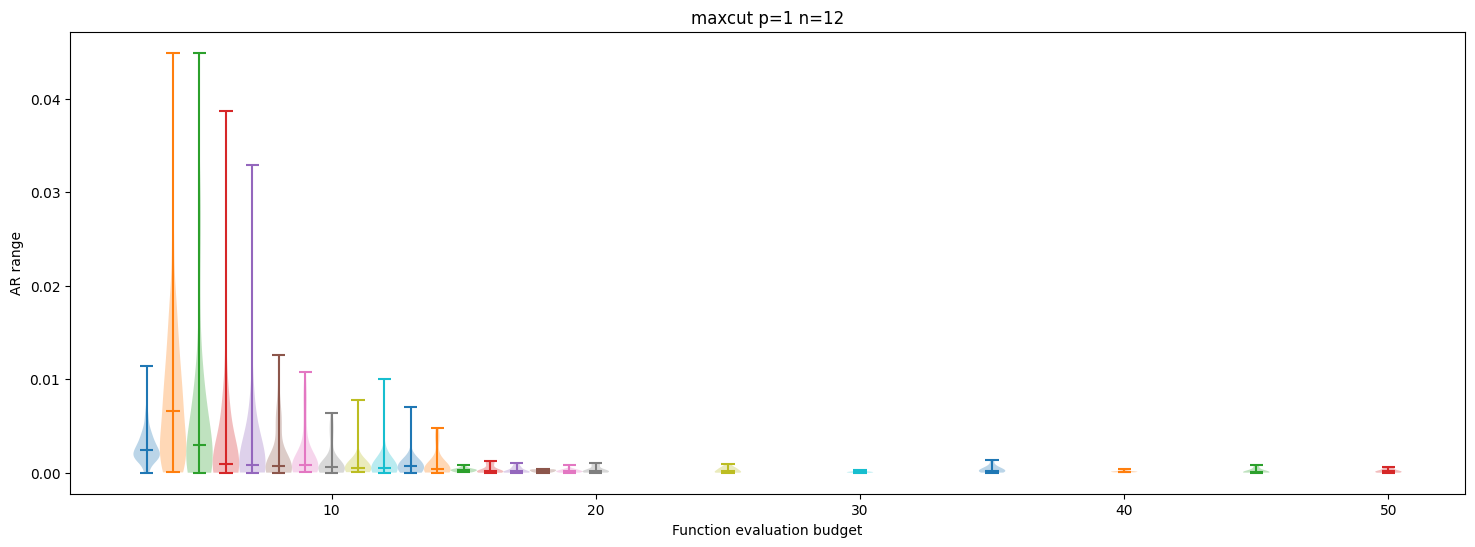

In [25]:
plt.figure(figsize=(18, 6))
for i, fev in enumerate(maxfev_pool):
    slice = np.array([result[:, j, j] for j in range(len(shots_pool))])
    ar_diff = (max_ar - initial_ar).flat[
        np.argmax(slice >= slice.max(axis=0) * 0.9, axis=0) == i
    ]
    plt.violinplot(
        ar_diff,
        [fev],
        widths=1,
        showmedians=True,
        # quantiles=[[0.25, 0.75]],
    )
    # plt.plot(
    #     fev,
    #     np.median(ar_diff),
    #     # yerr=np.std(ar_diff) / np.sqrt(len(ar_diff)),
    #     label=f"{fev=}",
    #     # fmt="o",
    #     marker="o"
    # )
    print(len(ar_diff))
    if i == len(maxfev_pool) - 1:
        print(ar_diff)
        print(slice.T[np.argmax(slice >= slice.max(axis=0), axis=0) == i])
plt.ylabel("AR range")
plt.xlabel("Function evaluation budget")
plt.title(f"{problem} {p=} {n=}")
# plt.ylim([0, 0.06])


Text(0, 0.5, 'AR range')

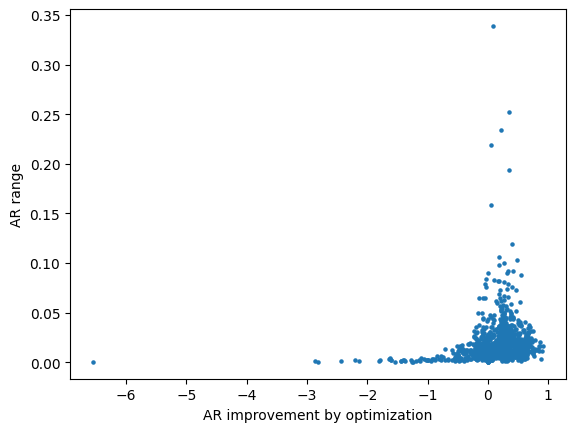

In [12]:
plt.figure()
plt.scatter(result[:,1,1], (max_ar - initial_ar).flat, s=5)
plt.xlabel("AR improvement by optimization")
plt.ylabel("AR range")


In [17]:
sorted_seeds = np.argsort(result[:,1,1])[-1::-1]
selected_seeds = sorted_seeds[np.isin(sorted_seeds, np.arange(1000)[np.where(np.abs((max_ar - initial_ar).flatten() - 0.05) < 0.015)])]
print(selected_seeds)
print(result[selected_seeds,1,1])
print((max_ar - initial_ar).flat[selected_seeds])


[437 348 621 164 289 436 513 996 515 311 887 151 999 111 848 475 715 177
 330 859 418 636 883 951 774 218 223 974 592 443 911 510 366  75 525  45
 578 353   8 531 213 689 494  37 628 624 629 642   7 610 323 105 820 470
 145 980 421 898 573 487  57 485 737 283 270 120 175 832  27 267 750 585
 772  44 467 478 880 244 788 230 914 875 938 858 295 708  66 994  92 417
 784 681 862 864 603 800]
[ 0.69017136  0.68456959  0.60624522  0.5516814   0.54079044  0.53314619
  0.53268941  0.52975315  0.51402868  0.50147891  0.49210923  0.46835419
  0.42854415  0.42040722  0.41327151  0.40743633  0.4058267   0.38932483
  0.38532174  0.38159062  0.37877898  0.37762926  0.36346659  0.35941038
  0.35805649  0.35406259  0.35226209  0.33721865  0.3303307   0.31804646
  0.30645679  0.30386825  0.30254492  0.29777116  0.2934008   0.29253742
  0.29100411  0.29011709  0.28740397  0.2869429   0.2808706   0.2773644
  0.27338099  0.27135602  0.2694956   0.26835916  0.26681298  0.26480697
  0.26029412  0.25858266  

In [86]:
print(np.argsort(result[:,0,0] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,1,1] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,2,2] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,3,3] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,4,4] - initial_ar.flat)[-1:-10:-1])


[ 77 259 437 990 566 218  31  10 737]
[386 170 164 155 909 293 738 127  82]
[630 414 547 298 308 829 434 356 144]
[154  31 881 608 195 917 905 612 662]
[ 31 164 913 255 155  58 358 235 825]


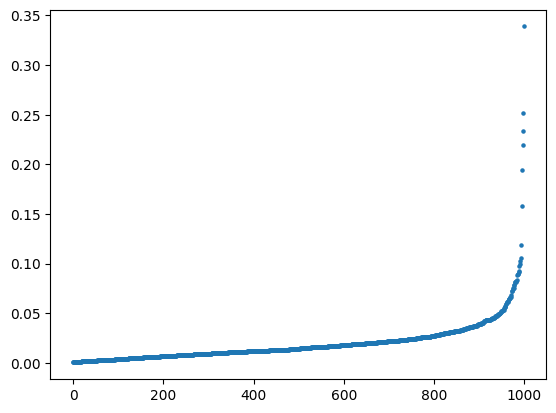

In [14]:
plt.figure()
plt.scatter(range(1000), np.sort((max_ar - initial_ar).flat), s=5)


In [69]:
xx = [11, 12, 14, 16, 20]
yy = [900, 800, 700, 600, 500]
zz = [z[0,7], z[2,6], z[4,5], z[8,4]]
zz = [z[0,8], z[1,7], z[3,6], z[5,5], z[9,4]]
zz = [z[i, i] for i in range(len(shots_pool))]
print(zz)


[0.1641994701218559, 0.1498850872342797, 0.13063953189897473, 0.13565727958185284, 0.11402204952509432, 0.11840735918195203, 0.08916160798395661, 0.10388720043365811, 0.06953981248694684, 0.06766277222210025, 0.060385457007876606, 0.04753195131317291]
